# ALS of Heidelberg - Height above ground

Notebook creator: Hannah Weiser, 2025

This demo uses a digital terrain model (DTM) of Heidelberg, Germany, which will be scanned by airborne laser scanning (ALS), maintaining a constant height above ground using interpolated trajectories.

In [1]:
from pathlib import Path
import helios
from helios.platforms import DynamicPlatformSettings  # these should not have to be imported extra?
from helios.settings import OutputFormat, LogVerbosity, FullWaveformSettings # these should not have to be imported extra?
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.interpolate import CubicSpline, make_interp_spline
import rasterio as rio

In [2]:
def interpolate_waypoints(t, x, y, time_step, b_spline_degree=3):
    """ Interpolates waypoints to create a smooth trajectory using cubic splines."""

    # Generate new time points
    new_t = np.arange(t[0], t[-1] + time_step, time_step)
    fx = make_interp_spline(t, x, b_spline_degree)
    fy = make_interp_spline(t, y, b_spline_degree)
    #fz = CubicSpline(t, z)
    
    # Interpolate all dimensions
    new_x = fx(new_t)
    new_y = fy(new_t)
    #new_z = fz(new_t)

    # return new fields
    return new_t, new_x, new_y


def compute_yaw_angles(x, y):
    yaw_angles = []
    for i in range(len(x) - 1):
        dx = x[i+1] - x[i]
        dy = y[i+1] - y[i]
        yaw = np.arctan2(dy, dx)
        # convert to degrees
        yaw = np.degrees(yaw)
        # Normalize yaw to be in the range [0, 360)
        if yaw < 0:
            yaw += 360
        # Append the yaw angle
        yaw_angles.append(yaw)
    
    # Append the last yaw angle
    yaw_angles.append(yaw_angles[-1])
    
    return np.array(yaw_angles)


def follow_height_above_ground(x, y, height_agl, dtm_file):
    coords = np.array([x, y]).T
    with rio.open(dtm_file) as src:
        z_vals = [z[0] + height_agl for z in src.sample(coords)]

    return np.array(z_vals)

## Creating the virtual scene

In [3]:
# load geotiff
dtm_file = "../data/sceneparts/tiff/dem_hd.tif"
dtm = helios.ScenePart.from_tiff(dtm_file)
#scene
scene = helios.StaticScene(scene_parts=[dtm])

## Scanner

In [4]:
from helios.scanner import leica_als50

scanner = leica_als50()

## Scanner settings

In [5]:
# these scanner settings will be shared between all legs
scanner_settings = helios.ScannerSettings(pulse_frequency=83_000,  # Hz
                                          scan_frequency=50,  # Hz
                                          scan_angle=30 * helios.units.deg,
                                          trajectory_time_interval=0.067  # s
                                         )

## Survey Route

In [6]:
# insert code here to simulate realistic trajectory that follows a more or less fixed height above the terrain.
waypoints = np.array([
    [477280.4, 5472582.6],
    [480531.0, 5472590.9],
    [480553.9, 5473285.3],
    [477304.6, 5473277.0],
    [477313.5, 5473863.9],
    [480567.7, 5473888.6]
])

# compute time assuming constant speed
speed_m_s = 200
distances_between_waypoints = np.linalg.norm(np.diff(waypoints, axis=0), axis=1)
times = [0]
for distance in distances_between_waypoints:
    times.append(times[-1] + distance / speed_m_s)

In [7]:
# interpolate waypoints to create a trajectory
time_step = 0.2  # seconds
height_agl = 1000  # m
t, x, y = interpolate_waypoints(times, waypoints[:, 0], waypoints[:, 1], time_step=time_step, b_spline_degree=1)

z = follow_height_above_ground(x, y, height_agl, dtm_file)

roll = np.zeros(len(x))  # Assuming roll is zero for simplicity
pitch = np.zeros(len(x))  # Assuming pitch is zero for simplicity
yaw = compute_yaw_angles(x, y)
waypoints_final = np.zeros(len(x), dtype={'names':('t', 'x', 'y', 'z', 'roll', 'pitch', 'yaw'),
                                          'formats':('f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8')})
waypoints_final['x'] = x
waypoints_final['y'] = y
waypoints_final['z'] = z
waypoints_final['t'] = t
waypoints_final['roll'] = roll
waypoints_final['pitch']= pitch
waypoints_final['yaw'] = yaw

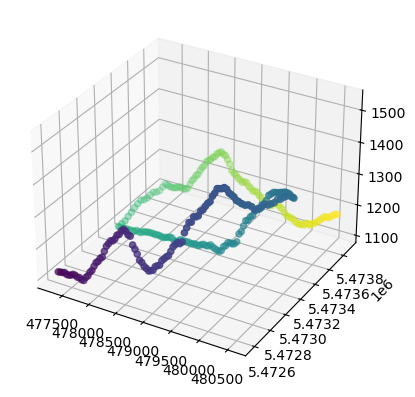

In [8]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(waypoints_final['x'], waypoints_final['y'], waypoints_final['z'], 'ro-', label='Trajectory', c=waypoints_final['t'])
#ax.set_box_aspect((np.ptp(waypoints_interp[:, 1]), np.ptp(waypoints_interp[:, 2]), np.ptp(waypoints_interp[:, 3])))
plt.show()
# plt.close()

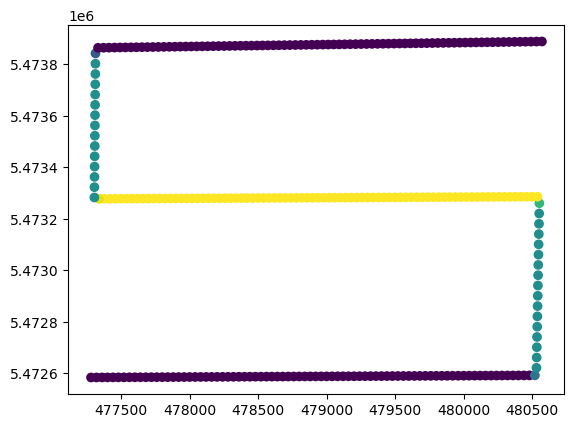

In [9]:
plt.scatter(waypoints_final['x'], waypoints_final['y'], c=waypoints_final['yaw'])
plt.show()

In [10]:
from helios.platforms import Platform
platform = Platform()
platform.load_interpolate_platform(
    waypoints_final,
    "data/platforms.xml",
    "sr22")

In [11]:
scanner_settings = helios.ScannerSettings(pulse_frequency=83_000,  # Hz
                                          scan_frequency=50,  # Hz
                                          scan_angle=30 * helios.units.deg,
                                          head_rotation=0,  # °/s
                                          trajectory_time_interval=0.06  # s
                                         )
trajectory_settings = helios.platforms.TrajectorySettings(start_time=0, end_time=55.2
                                         )

In [12]:
survey = helios.Survey(scanner=scanner, platform=platform, scene=scene)
survey.add_leg(scanner_settings=scanner_settings, trajectory_settings=trajectory_settings)

In [13]:
waypoints_final

array([( 0. , 477280.4       , 5472582.6       , 1119., 0., 0., 1.46297279e-01),
       ( 0.2, 477320.39986961, 5472582.70213466, 1120., 0., 0., 1.46297280e-01),
       ( 0.4, 477360.39973921, 5472582.80426931, 1121., 0., 0., 1.46297279e-01),
       ( 0.6, 477400.39960882, 5472582.90640397, 1123., 0., 0., 1.46297280e-01),
       ( 0.8, 477440.39947842, 5472583.00853863, 1119., 0., 0., 1.46297279e-01),
       ( 1. , 477480.39934803, 5472583.11067329, 1119., 0., 0., 1.46297280e-01),
       ( 1.2, 477520.39921764, 5472583.21280794, 1121., 0., 0., 1.46297279e-01),
       ( 1.4, 477560.39908724, 5472583.3149426 , 1126., 0., 0., 1.46297280e-01),
       ( 1.6, 477600.39895685, 5472583.41707726, 1125., 0., 0., 1.46297277e-01),
       ( 1.8, 477640.39882646, 5472583.51921192, 1121., 0., 0., 1.46297281e-01),
       ( 2. , 477680.39869606, 5472583.62134658, 1122., 0., 0., 1.46297280e-01),
       ( 2.2, 477720.39856567, 5472583.72348123, 1117., 0., 0., 1.46297277e-01),
       ( 2.4, 477760.3984352

## Executing the survey

In [ ]:
points, trajectory = survey.run(verbosity=LogVerbosity.VERBOSE)

## Visualizing the results

Now we can display a couple of 2D plots of the simulated point cloud.

NameError: name 'waypoints_final' is not defined